**Project: Click Prediction with Cloud-Integrated Pipeline**    
**Author**: Chien-Hao Wang   
**Date**: 25/11/2025    

This script simulates a production-level workflow:
1. Cloud Data Ingestion (Connect Google BigQuery)
2. Strategic Preprocessing (Imputation & Encoding)
3. Model Benchmarking (Logistic vs RF vs XGBoost)
4. Final Model Training & Evaluation
5. Advanced Visualization (SHAP, ROC, Gain Chart)

In [57]:
# --- 1. Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.cloud import bigquery

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, f1_score, roc_curve, auc)

# Explainability
import shap
import scikitplot as skplt # Optional, logic implemented manually below if not installed

# Configuration for Plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Data Ingestion (Cloud Simulation)

In a real-world scenario, data is rarely stored in local CSVs. Here, we simulate an ETL (Extract, Transform, Load) process fetching data from a Cloud Data Warehouse (**Google BigQuery**).

In [58]:
# --- Configuration ---
# Set the path to your Google Cloud Service Account Key
# In a real production environment, use environment variables for security.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'service_account.json'

# Initialize BigQuery Client
client = bigquery.Client()

# Test Connection
query = "SELECT 'Connection Successful' as status"
try:
    df = client.query(query).to_dataframe()
    print("Connected Successful !")
    print(df)
except Exception as e:
    print("Fail Connected, See error messages below:")
    print(e)

c:\Users\jeffs\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Connected Successful !
                  status
0  Connection Successful


In [59]:
# --- Data Extraction (ETL) ---
query = """
    SELECT *
    FROM `ad-click-portfolio.marketing_data.ad_clicks_raw`
    LIMIT 10000; 
"""

print("Attempting to fetch data from BigQuery...")
try:
    df = client.query(query).to_dataframe()
    print(f"Data successfully loaded. Shape: {df.shape}")
except Exception as e:
    print(f"Connection failed: {e}")

Attempting to fetch data from BigQuery...


c:\Users\jeffs\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Data successfully loaded. Shape: (10000, 9)


# Strategic Data Preprocessing & Exploratory Data Analysis (EDA)

Initial EDA revealed a critical challenge: High Missingness.

- Age: ~48% missing.
- Gender: ~47% missing.
- Device Type: 20% missing.
- Ad Position: 20% missing.
- Browsing History: ~48% missing.
- Time of Day: 20% missing.

The Strategy: "Missingness as a Signal" Instead of dropping rows (which would lose 50% of our data), we adopt an imputation strategy:

1. Numerical (Age): Impute with the Median to be robust against outliers.
2. Categorical (Gender, Device): Explicitly label as "Unknown".
- Hypothesis: Users who do not share demographic data may behave differently. We want the model to learn this pattern.

In [60]:
# --- Data Integrity Check ---
# Basic info and missing values
info = df.info()
missing_values = df.isnull().sum()
print(missing_values)

# Calculate CTR
ctr = df['click'].mean()

# Checking if 'Missingness' correlates with Clicks
# This proves we shouldn't just drop rows.

features_with_missing = ['age', 'gender', 'device_type', 'browsing_history']

print("--- Impact of Missing Data on Click Rate ---")
for col in features_with_missing:
    # Create a temporary flag: Is the data missing?
    df[f'{col}_missing_flag'] = df[col].isnull()
    
    # Calculate CTR for Missing vs. Present data
    ctr_analysis = df.groupby(f'{col}_missing_flag')['click'].mean()
    print(f"\nFeature: {col}")
    print(ctr_analysis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  Int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  Int64  
dtypes: Int64(2), float64(1), object(6)
memory usage: 722.8+ KB
id                     0
full_name              0
age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64
--- Impact of Missing Data on Click Rate ---

Feature: age
age_missing_fla

c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


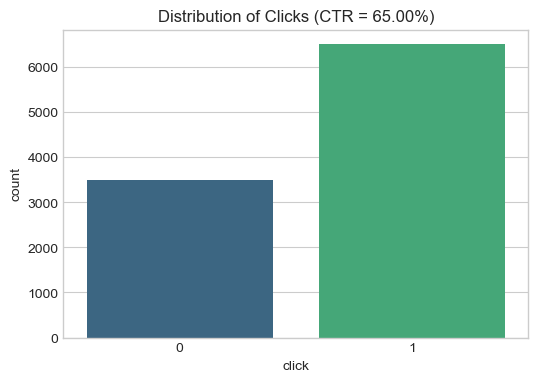

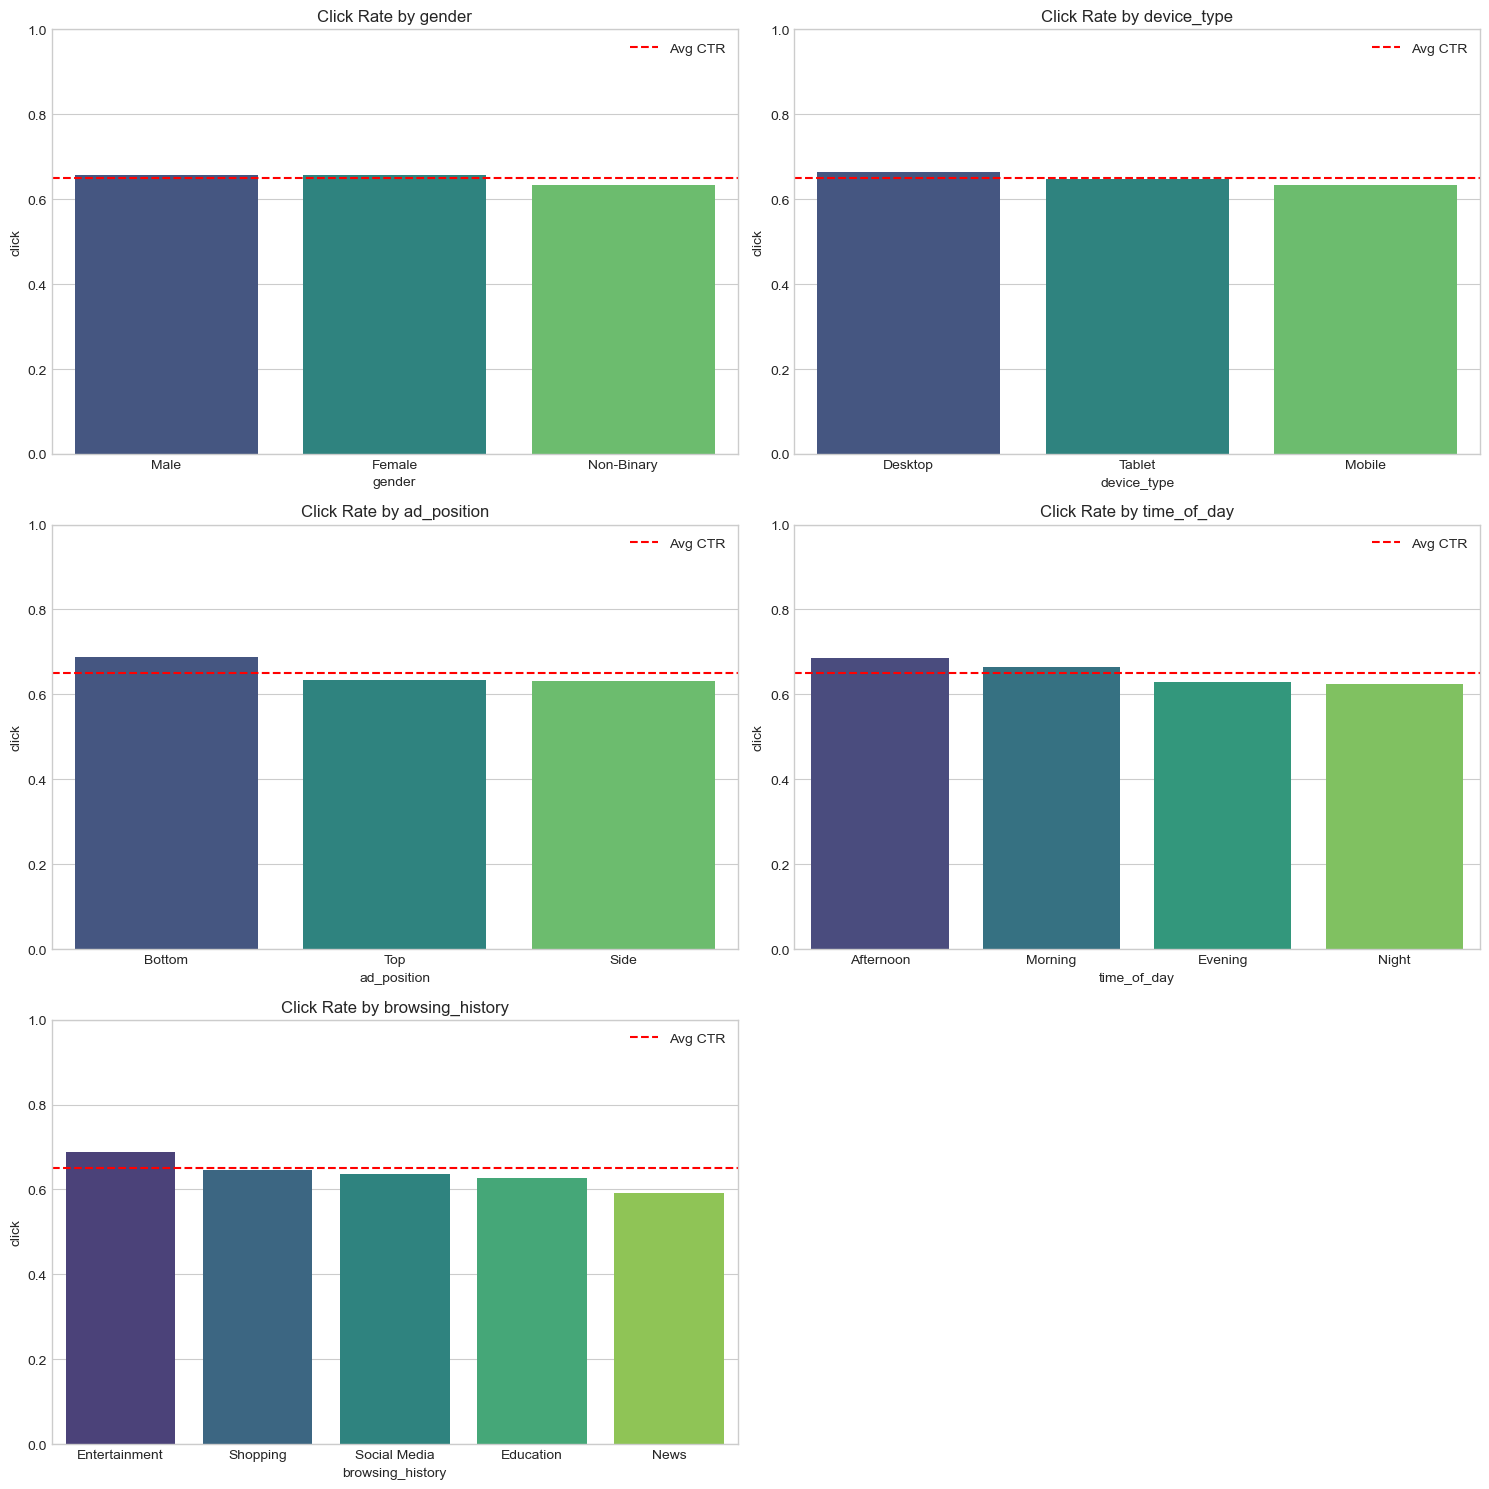

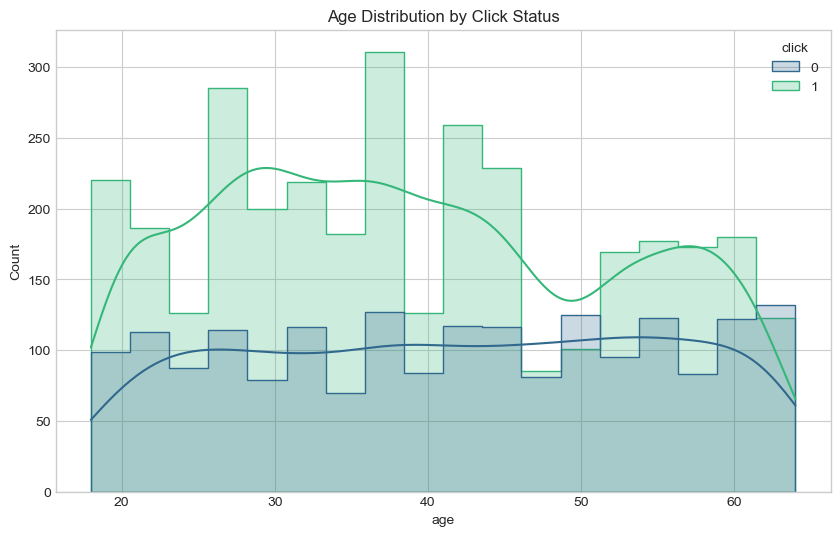

In [61]:
# --- Exploratory Data Analysis (EDA) ---

# 1. Target Variable Distribution
# Rationale: Understanding class imbalance is crucial for model selection.
plt.figure(figsize=(6, 4))
sns.countplot(x='click', data=df, palette='viridis')
plt.title(f'Distribution of Clicks (CTR = {ctr:.2%})')
plt.savefig('ctr_distribution.png')

# 2. Click Rate by Categorical Features
categorical_cols = ['gender', 'device_type', 'ad_position', 'time_of_day', 'browsing_history']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Calculate click rate for each category
    click_rate = df.groupby(col)['click'].mean().reset_index().sort_values('click', ascending=False)
    sns.barplot(x=col, y='click', data=click_rate, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Click Rate by {col}')
    axes[i].set_ylim(0, 1)
    axes[i].axhline(ctr, color='red', linestyle='--', label='Avg CTR') # Add average CTR line
    axes[i].legend()

# Remove the last empty subplot if odd number of charts
if len(categorical_cols) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('categorical_click_rates.png')

# 3. Age Distribution by Click
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='click', kde=True, element="step", palette='viridis')
plt.title('Age Distribution by Click Status')
plt.savefig('age_distribution.png')

# Model Benchmarking
To ensure the deployment of the most effective model, we conduct a rigorous **Champion vs. Challenger** benchmark comparison across three algorithm classes:

1. **Logistic Regression (Baseline)**: Tests for linear separability.
2. **Random Forest (Challenger)**: Tests bagging ensembles for non-linear stability.
3. **XGBoost (Challenger)**: Tests gradient boosting for maximum predictive power.

**Metric of Choice**: ROC-AUC (Area Under the Receiver Operating Characteristic Curve) to measure discrimination power.

In [62]:
# --- FEATURE ENCODING (Preparation for AI Model) ---

# We need to convert text to numbers. We will use One-Hot Encoding.
# Drop 'id' and 'full_name' as they have no predictive power.
# Drop original 'age' (use 'age_clean' instead).

# A. Handle Numerical Missingness (Age) -> Median Imputation
df['age'] = df['age'].fillna(df['age'].median())

# B. Handle Categorical Missingness -> Label as "Unknown"
categorical_cols = ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# C. Feature Selection & Encoding
# Drop identifiers that have no predictive power
X = df.drop(['id', 'full_name', 'click'], axis=1)
y = df['click']

# One-Hot Encoding for categorical variables
# drop_first=False allows us to explicitly see the impact of "Unknown" categories
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

--- Starting Model Benchmarking ---
Logistic Regression: AUC = 0.5501
Random Forest: AUC = 0.7570


c:\Users\jeffs\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:09:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: AUC = 0.7927


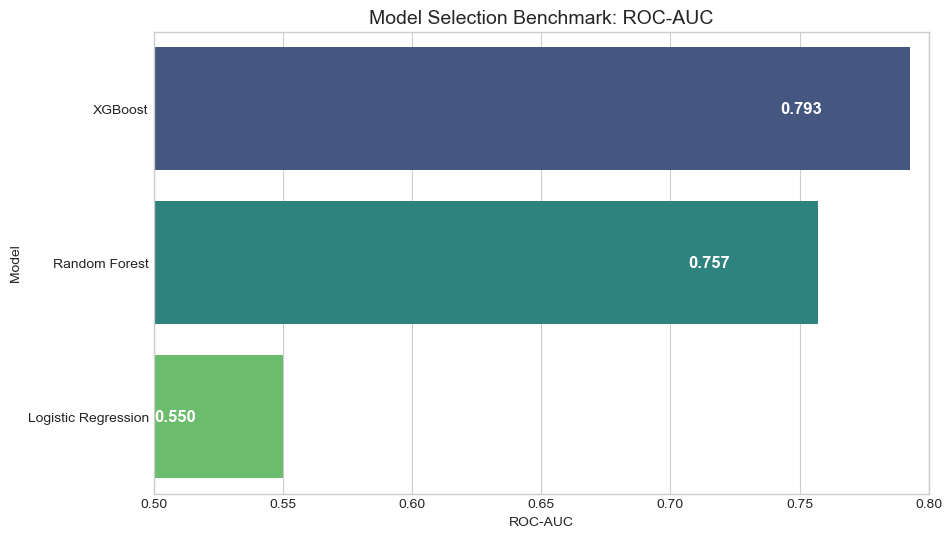

In [63]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []
print("--- Starting Model Benchmarking ---")

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    # Predict Probability (needed for AUC)
    y_prob = model.predict_proba(X_test)[:, 1]
    # Score
    auc_score = roc_auc_score(y_test, y_prob)
    
    results.append({"Model": name, "ROC-AUC": auc_score})
    print(f"{name}: AUC = {auc_score:.4f}")

# Visualisation
benchmark_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="ROC-AUC", y="Model", data=benchmark_df, palette="viridis")
for i, v in enumerate(benchmark_df["ROC-AUC"]):
    ax.text(v - 0.05, i, f"{v:.3f}", color='white', va='center', fontweight='bold', fontsize=12)
plt.title('Model Selection Benchmark: ROC-AUC', fontsize=14)
plt.xlim(0.5, 0.8)
plt.show()

# Final Model Training & Evaluation 
Based on the benchmark, **XGBoost** is selected as the Champion model due to its superior discriminative power (highest AUC). We now proceed to a deep-dive evaluation of the final model.

**Evaluation Focus:**   
1. Confusion Matrix: To understand False Positives vs False Negatives.
2. Cumulative Gain Chart: To quantify the Business Lift (How much better is the model than random guessing?).

In [66]:
# --- 5. Final Model Training & Advanced Evaluation ---

# Retrain the Champion Model (XGBoost)

# --- MODEL TRAINING ---

# Split data: 80% Train, 20% Test
# stratify=y ensures the proportion of clicks (65%) is maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Initialise XGBoost Classifier
# use_label_encoder=False and eval_metric='logloss' to suppress warnings
model = XGBClassifier(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=5,           # Depth of trees (controls complexity)
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
print("\nTraining XGBoost Model...")
model.fit(X_train, y_train)
print("Model Training Complete.")


Training Data Shape: (8000, 28)
Testing Data Shape: (2000, 28)

Training XGBoost Model...


c:\Users\jeffs\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Training Complete.



Model Accuracy: 70.65%

Classification Report:

              precision    recall  f1-score   support

         0.0       0.79      0.22      0.34       700
         1.0       0.70      0.97      0.81      1300

    accuracy                           0.71      2000
   macro avg       0.74      0.59      0.58      2000
weighted avg       0.73      0.71      0.65      2000



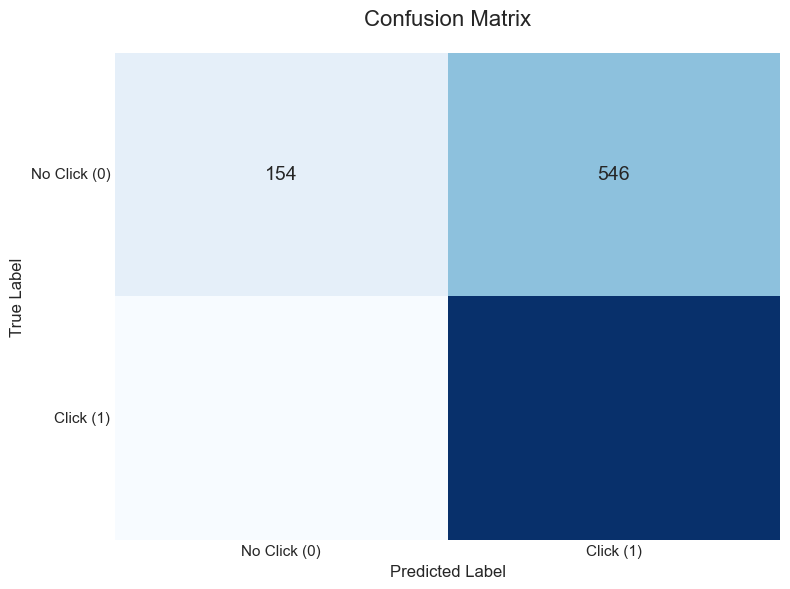

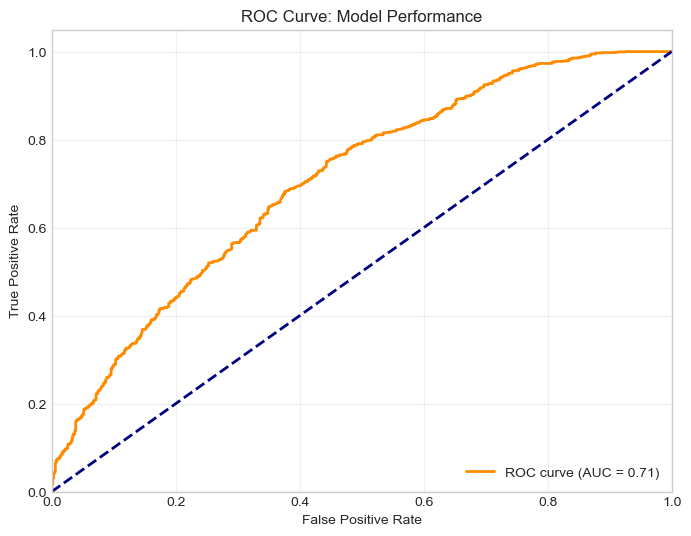

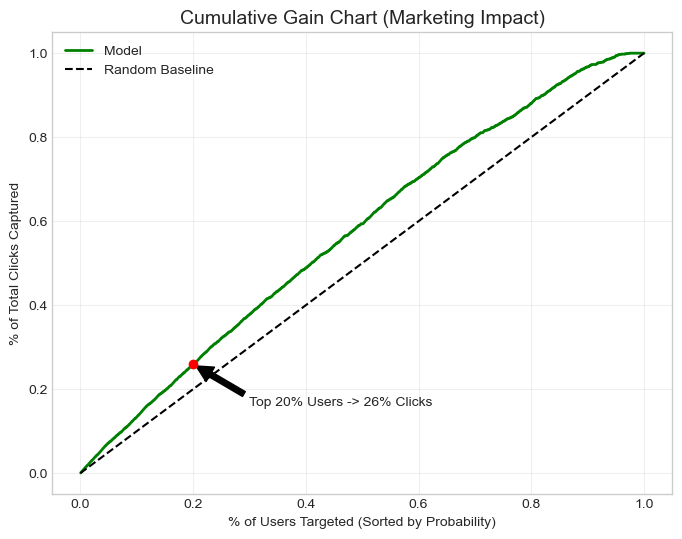

In [67]:
# --- EVALUATION ---

# Make predictions
y_pred = model.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {acc:.2%}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Visualise Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

ax.set_xticklabels(['No Click (0)', 'Click (1)'], fontsize=11)
ax.set_yticklabels(['No Click (0)', 'Click (1)'], fontsize=11, rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

y_probas = model.predict_proba(X_test)

# --- 1. ROC Curve (Technical View) ---
plt.figure(figsize=(8, 6))
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model Performance')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('roc_curve.png', bbox_inches='tight')
plt.show()

# --- B. Cumulative Gain Chart (Business Lift) ---
# Create a dataframe for Gain calculation

results = pd.DataFrame({'y_true': y_test, 'y_prob': y_probas[:, 1]})
results = results.sort_values(by='y_prob', ascending=False)

results['cumulative_click'] = results['y_true'].cumsum()
total_clicks = results['y_true'].sum()
results['gain'] = results['cumulative_click'] / total_clicks
results['percentage'] = np.arange(1, len(results) + 1) / len(results)

plt.figure(figsize=(8, 6))
plt.plot(results['percentage'], results['gain'], label='Model', color='green', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')

plt.title('Cumulative Gain Chart (Marketing Impact)', fontsize=14)
plt.xlabel('% of Users Targeted (Sorted by Probability)')
plt.ylabel('% of Total Clicks Captured')
plt.grid(alpha=0.3)
plt.legend()

# Annotate Top 20% Lift
top_20_gain = results[results['percentage'] <= 0.2]['gain'].max()
plt.scatter([0.2], [top_20_gain], color='red', zorder=5)
plt.annotate(f'Top 20% Users -> {top_20_gain:.0%} Clicks', 
             xy=(0.2, top_20_gain), xytext=(0.3, top_20_gain-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.savefig('gain_chart.png', bbox_inches='tight')
plt.show()

# Explainable AI: Decoding the "Black Box"
To provide actionable insights to stakeholders, we use **SHAP (SHapley Additive exPlanations)**. This allows us to understand why the model predicts a user will click.

**Key Questions to Answer:**
- Does the "Unknown" gender actually matter?
- Which content category drives the most engagement?


Generating SHAP Interpretation...


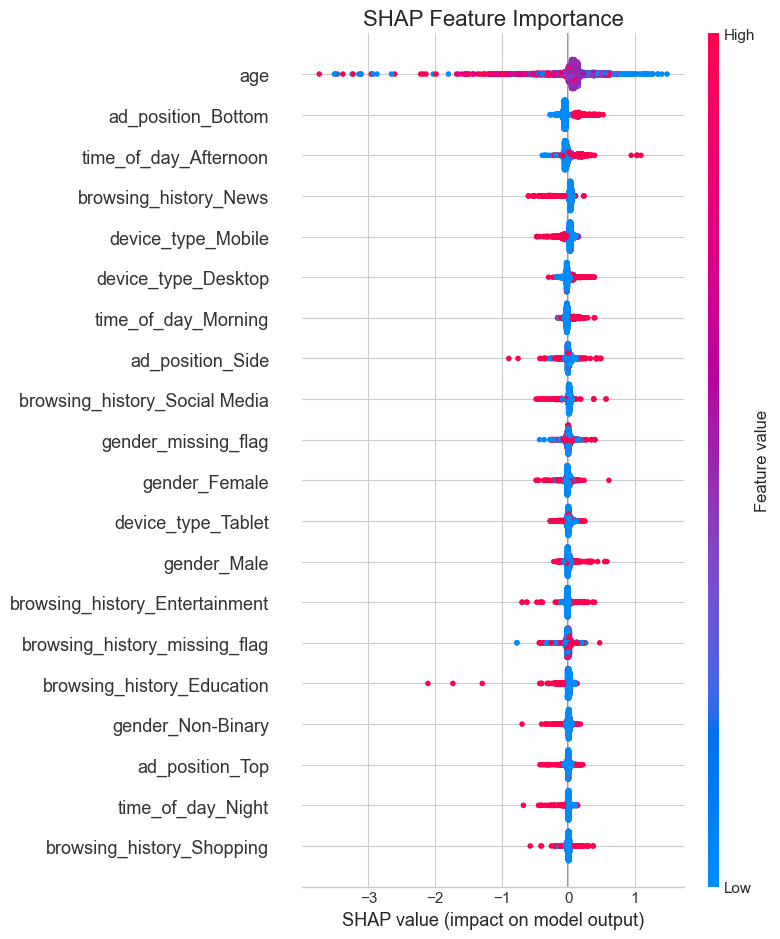

In [68]:
# --- EXPLAINABLE AI (SHAP) ---

print("\nGenerating SHAP Interpretation...")

# Create a TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Shows which features matter most and how they affect the output
plt.figure(figsize=(6, 5))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Feature Importance', fontsize=16)
plt.tight_layout()
plt.savefig('shap_summary.png') # Save for GitHub
plt.show()

# Strategic Recommendations
Based on the analysis above:    
1. **Stop Spending on News:** The SHAP analysis confirms that `browsing_history_News` is a strong negative driver.
2. **Place most of ads at the bottom:** `ad_position_Bottom` is the strongest predictor of positive clicks.
3. **Focus on desktop device users":** The model validates that users with desktops (`device_type_Desktop`) are a valuable segment, comparing with users with mobile phones.
4. **Operational Efficiency:** Using this model to target the top 20% of the audience would yield approximately **26% of total clicks**, representing a significant efficiency lift over random targeting.